# **Most Basic Graph Neural Network with Gaussian Filter on MNIST**

## **Libraries**

In [3]:
from torch.utils.data.dataset import Subset
from scipy.spatial.distance import cdist
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
RANDOM_SEED = 1
LEARNING_RATE = 0.05
NUM_EPOCHS = 20
BATCH_SIZE = 128
IMG_SIZE = 28

In [6]:
NUM_CLASSES = 10

## **MNIST Dataset**

In [7]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

In [8]:
custom_transform = transforms.Compose([transforms.ToTensor()])

In [9]:
train_and_valid = datasets.MNIST(root='data', train=True, transform=custom_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=custom_transform, download=True)

In [10]:
train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [12]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Building the model**

In [13]:
def precompute_adjacency_matrix(img_size):
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    
    coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
    dist = cdist(coord, coord, metric='euclidean')
    sigma = 0.05 * np.pi
    A = np.exp(- dist / sigma ** 2)
    A[A < 0.01] = 0
    A = torch.from_numpy(A).float()
    D = A.sum(1)
    D_hat = (D + 1e-5) ** (-0.5)
    A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1) 
    
    return A_hat

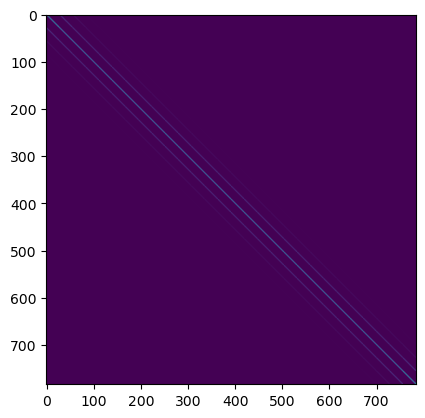

In [14]:
plt.imshow(precompute_adjacency_matrix(28));

In [15]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        A = precompute_adjacency_matrix(img_size)
        self.register_buffer('A', A)

        
    def forward(self, x):
        
        B = x.size(0)
        A_tensor = self.A.unsqueeze(0)
        A_tensor = self.A.expand(B, -1, -1)
        x_reshape = x.view(B, -1, 1)
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))
        
        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [16]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

In [17]:
model = model.to(DEVICE)

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

## **Training phase**

In [19]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [20]:
start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | ' f'Batch {batch_idx:03d}/{len(train_loader):03d} |' f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False):
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/020 | Batch 000/461 | Cost: 2.2449
Epoch: 001/020 | Batch 150/461 | Cost: 0.8476
Epoch: 001/020 | Batch 300/461 | Cost: 0.5709
Epoch: 001/020 | Batch 450/461 | Cost: 0.5937
Epoch: 001/020
Train ACC: 86.90 | Validation ACC: 92.10
Time elapsed: 0.79 min
Epoch: 002/020 | Batch 000/461 | Cost: 0.5034
Epoch: 002/020 | Batch 150/461 | Cost: 0.4132
Epoch: 002/020 | Batch 300/461 | Cost: 0.4706
Epoch: 002/020 | Batch 450/461 | Cost: 0.3690
Epoch: 002/020
Train ACC: 88.33 | Validation ACC: 92.60
Time elapsed: 1.56 min
Epoch: 003/020 | Batch 000/461 | Cost: 0.4121
Epoch: 003/020 | Batch 150/461 | Cost: 0.4513
Epoch: 003/020 | Batch 300/461 | Cost: 0.4056
Epoch: 003/020 | Batch 450/461 | Cost: 0.2735
Epoch: 003/020
Train ACC: 88.94 | Validation ACC: 93.20
Time elapsed: 2.30 min
Epoch: 004/020 | Batch 000/461 | Cost: 0.4208
Epoch: 004/020 | Batch 150/461 | Cost: 0.4065
Epoch: 004/020 | Batch 300/461 | Cost: 0.3819
Epoch: 004/020 | Batch 450/461 | Cost: 0.2904
Epoch: 004/020
Train ACC: 8

## **Evaluation**

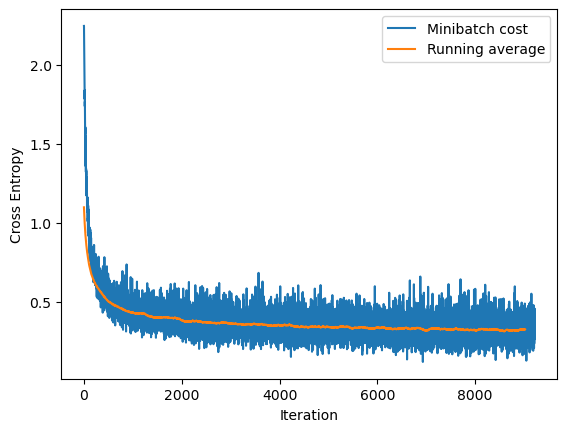

In [21]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

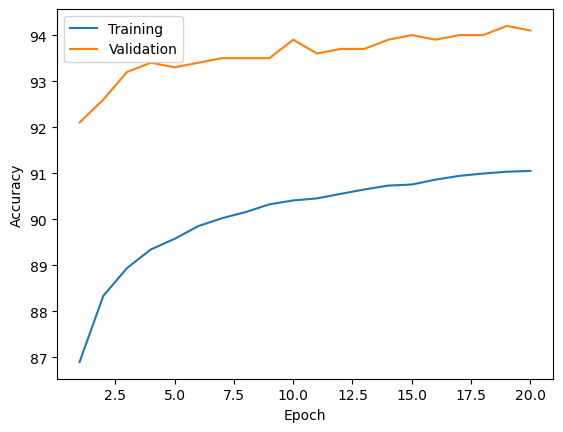

In [22]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 94.10%
Test ACC: 91.59%
